<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-decision-trees/blob/master/Assignment_8_Apply_Decision_Trees_on_Amazon_reviews_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
from google.colab import drive, files
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp drive/My\ Drive/Colab\ Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip -d amazon_fine_food_reviews_data

 96% 240M/251M [00:01<00:00, 177MB/s]
100% 251M/251M [00:01<00:00, 144MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon_fine_food_reviews_data/Reviews.csv  
  inflating: amazon_fine_food_reviews_data/database.sqlite  
  inflating: amazon_fine_food_reviews_data/hashes.txt  


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon_fine_food_reviews_data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time DESC LIMIT 150000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data['Time'].values

Number of data points in our data (150000, 10)


array([1351209600, 1351209600, 1351209600, ..., 1329868800, 1329868800,
       1329868800])

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(105511, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

70.34066666666666

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(105511, 10)


1    87111
0    18400
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.
This tea tastes fresh! It has quickly become one of my favorites and I drink it almost daily. If you let it steep too long, it can definitely become too strong - but otherwise I really like the balance of flavors. You don't need to add anything to this tea, but it is good with a bit of milk and sugar or just sugar.<br /><br />It smells really good. Anytime someone comes to our house when we've recently made a pot of this tea they comment on the nice aroma. I've even gotten comments from people who don't like tea.<br /><br />If you like tea, give this a shot and you won't be disappointed. I'll be getting a second bag soon.
I received medium roast. Didn't receive the correct coffee shown on picture. Disappointed by this. I suppose ill try as its a lot of my trouble to return
Just got our package in the mail and it not only looks great but the package w

In [9]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [10]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.
This tea tastes fresh! It has quickly become one of my favorites and I drink it almost daily. If you let it steep too long, it can definitely become too strong - but otherwise I really like the balance of flavors. You don't need to add anything to this tea, but it is good with a bit of milk and sugar or just sugar.It smells really good. Anytime someone comes to our house when we've recently made a pot of this tea they comment on the nice aroma. I've even gotten comments from people who don't like tea.If you like tea, give this a shot and you won't be disappointed. I'll be getting a second bag soon.
I received medium roast. Didn't receive the correct coffee shown on picture. Disappointed by this. I suppose ill try as its a lot of my trouble to return
Just got our package in the mail and it not only looks great but the package was a lot heavier than I 

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I received medium roast. Did not receive the correct coffee shown on picture. Disappointed by this. I suppose ill try as its a lot of my trouble to return


In [13]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I received medium roast Did not receive the correct coffee shown on picture Disappointed by this I suppose ill try as its a lot of my trouble to return


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm_notebook as tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [17]:
preprocessed_reviews[1500]

'received medium roast not receive correct coffee shown picture disappointed suppose ill try lot trouble return'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

## [4.1] BAG OF WORDS

In [18]:
#BoW
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= .20, shuffle=False, stratify= None) 

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(x_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


final_counts_test = count_vect.transform(x_test)


some feature names  ['aa', 'aafco', 'aback', 'abandoned', 'abc', 'abdominal', 'ability', 'able', 'able add', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (84408, 49310)
the number of unique words  49310


## [4.3] TF-IDF

In [38]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tfidf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tfidf_vect.transform(x_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

final_tf_idf_test= tfidf_vect.transform(x_test)

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandoned', 'abc', 'abdominal', 'ability', 'able', 'able add', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (84408, 49310)
the number of unique words including both unigrams and bigrams  49310


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [40]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.835039496421814), ('awesome', 0.8348562717437744), ('fantastic', 0.8245441913604736), ('excellent', 0.8115736246109009), ('wonderful', 0.795196533203125), ('terrific', 0.7789592742919922), ('perfect', 0.7753635048866272), ('amazing', 0.7023946642875671), ('fabulous', 0.6919319033622742), ('nice', 0.6912268400192261)]
[('greatest', 0.8819640874862671), ('tastiest', 0.7315837740898132), ('best', 0.7287357449531555), ('vile', 0.7012174129486084), ('nastiest', 0.6759110689163208), ('smoothest', 0.6741212010383606), ('strangest', 0.6542589664459229), ('disgusting', 0.6343207359313965), ('freshest', 0.6258910298347473), ('horrible', 0.6052244305610657)]


In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17356
sample words  ['healthy', 'dog', 'food', 'good', 'digestion', 'also', 'small', 'puppies', 'eats', 'required', 'amount', 'every', 'feeding', 'partner', 'happy', 'tea', 'feeling', 'much', 'better', 'since', 'starting', 'drink', 'drinking', 'hot', 'normal', 'iced', 'chilled', 'likes', 'refreshing', 'nature', 'purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'lollipops']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
    
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))    
    






84408
50



21103
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features = 5000)
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
  
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())


tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    

    


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV as RSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight

cross= 2

# Please write all the code with proper documentation
depth =  [1, 5, 10, 50, 100, 500, 100]
min_samples_split = [5, 10, 100, 500]

estimator= DecisionTreeClassifier(criterion='gini', splitter='best', class_weight= 'balanced')
param_distributions={
    'max_depth' : depth,
    'min_samples_split' : min_samples_split
}

train= final_counts
test= final_counts_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)


Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  9.7min finished


best score :  0.8175476154573699
best parameter :  {'min_samples_split': 500, 'max_depth': 50}


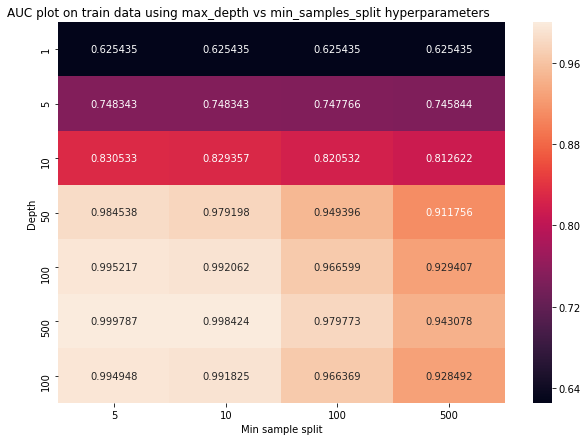

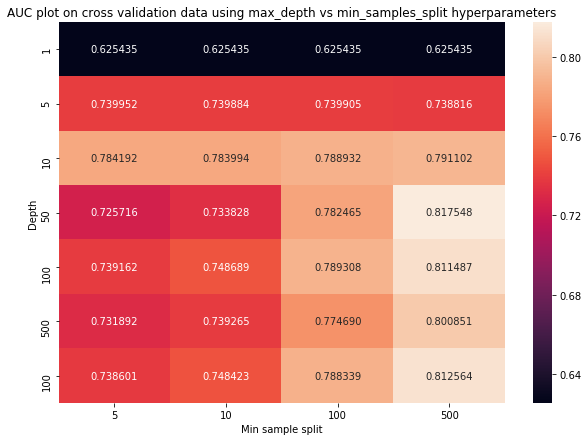

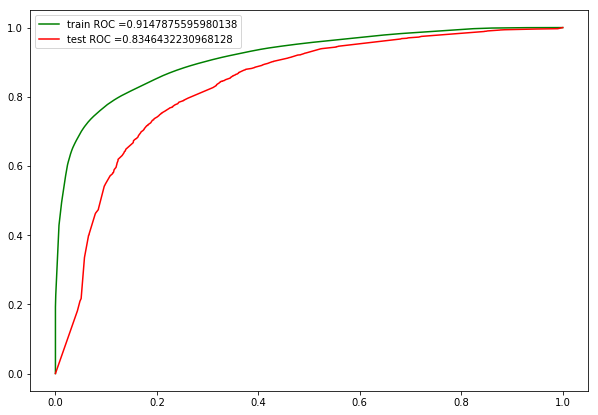

Train confusion matrix: 
[[13006  1585]
 [15093 54724]]

Test confusion matrix: 
[[ 2980   829]
 [ 4156 13138]]

Test Sensitivity or True Positive Rate: 0.42
Test Specificity or False Negative Rate: 0.94


In [31]:

# Plotting train AUC
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))  
ax= sns.heatmap((np.reshape(train_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")

ax.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on train data using max_depth vs min_samples_split hyperparameters                 ")
fig,ax_1= plt.subplots(figsize=(10,7))

ax_1= sns.heatmap((np.reshape(cv_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")
ax_1.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on cross validation data using max_depth vs min_samples_split hyperparameters")


fig, ax2 = plt.subplots(figsize=(10,7))
score_roc_train = best_model.predict_proba(train)[:,1]
score_roc_test = best_model.predict_proba(test)[:,1]
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_BOW= grid.best_estimator_
AUC_BOW= grid.best_score_
CM_BOW= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [32]:
d= count_vect.vocabulary_
d= {value: key for key, value in d.items()}
important_feats= []
feat_importances = (best_model.feature_importances_.argsort()[::-1][0:20])
for i in (feat_importances):
  important_feats.append(d[i])
  
print("Top 20 important feature set")  
print(important_feats)


Top 20 important feature set
['not', 'great', 'love', 'best', 'disappointed', 'delicious', 'good', 'perfect', 'loves', 'money', 'nice', 'bad', 'excellent', 'easy', 'favorite', 'not good', 'unfortunately', 'wonderful', 'awful', 'horrible']


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

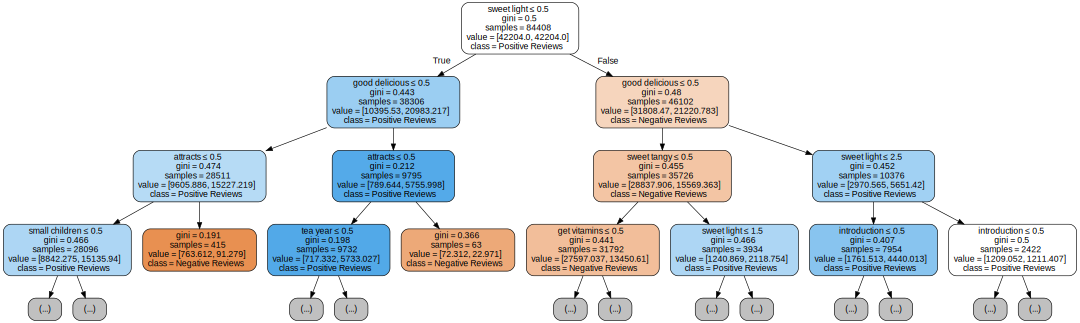

In [33]:
# Please write all the code with proper documentation
%matplotlib inline


from graphviz import Source
import pydot

pydot.Dot.set_graph_defaults
dot_tree= export_graphviz(best_model, out_file= None, 
                          filled= True, rounded= True, 
                          class_names= ['Negative Reviews', 'Positive Reviews'],
                          #class_names= best_model.classes_,
                          max_depth= 3,
                          feature_names= list(d.values()), 
                          #class_names=best_model.target_names, 
                          special_characters= True)


pdot = pydot.graph_from_dot_data(dot_tree)
pdot[0].set_graph_defaults(size = "\"15,15\"")
graph = Source(pdot[0].to_string()) 
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed: 10.7min finished


best score :  0.8061644325235354
best parameter :  {'min_samples_split': 500, 'max_depth': 50}


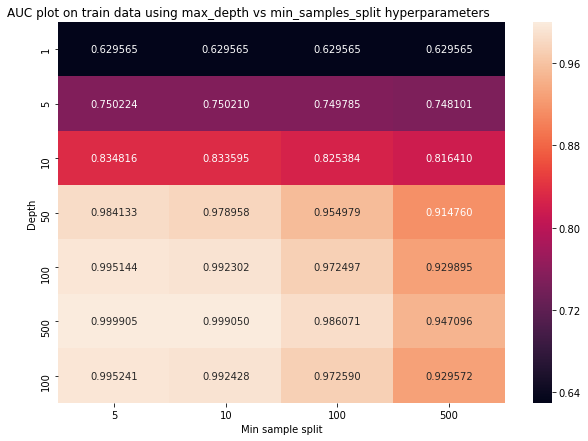

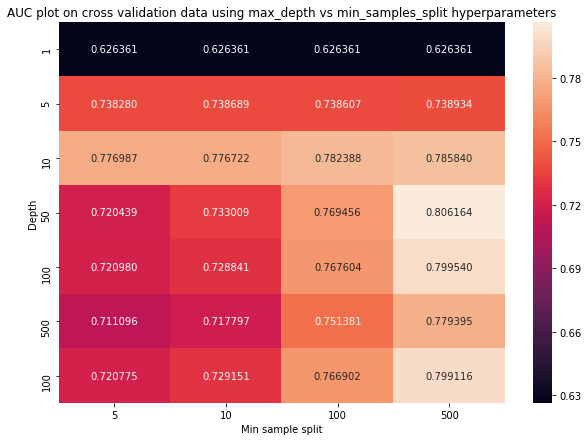

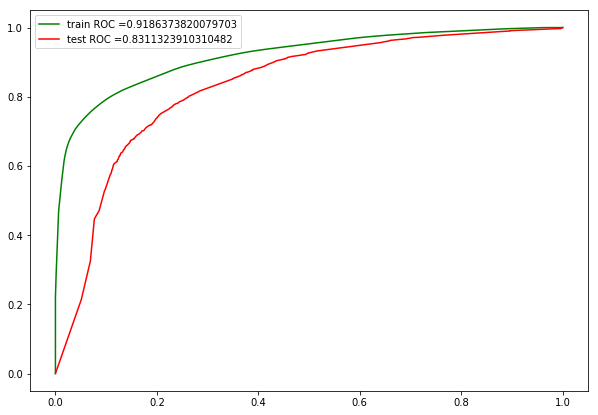

Train confusion matrix: 
[[13114  1477]
 [14419 55398]]

Test confusion matrix: 
[[ 2949   860]
 [ 4019 13275]]

Test Sensitivity or True Positive Rate: 0.42
Test Specificity or False Negative Rate: 0.94


In [45]:
# Please write all the code with proper documentation
depth =  [1, 5, 10, 50, 100, 500, 100]
min_samples_split = [5, 10, 100, 500]

estimator= DecisionTreeClassifier(criterion='gini', splitter='best', class_weight= 'balanced')
param_distributions={
    'max_depth' : depth,
    'min_samples_split' : min_samples_split
}

train= final_tf_idf
test= final_tf_idf_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)

# Plotting train AUC
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))  
ax= sns.heatmap((np.reshape(train_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")

ax.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on train data using max_depth vs min_samples_split hyperparameters                 ")
fig,ax_1= plt.subplots(figsize=(10,7))

ax_1= sns.heatmap((np.reshape(cv_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")
ax_1.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on cross validation data using max_depth vs min_samples_split hyperparameters")


fig, ax2 = plt.subplots(figsize=(10,7))

score_roc_train = best_model.predict_proba(train)[:,1]
score_roc_test = best_model.predict_proba(test)[:,1]
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDF= grid.best_estimator_
AUC_TFIDF= grid.best_score_
CM_TFIDF= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [46]:
d= tfidf_vect.vocabulary_
d= {value: key for key, value in d.items()}
important_feats= []
feat_importances = (best_model.feature_importances_.argsort()[::-1][0:20])
for i in (feat_importances):
  important_feats.append(d[i])
  
print("Top 20 important feature set")  
print(important_feats)


Top 20 important feature set
['not', 'great', 'love', 'best', 'delicious', 'disappointed', 'good', 'perfect', 'loves', 'money', 'nice', 'bad', 'easy', 'excellent', 'favorite', 'unfortunately', 'thought', 'awful', 'wonderful', 'horrible']


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

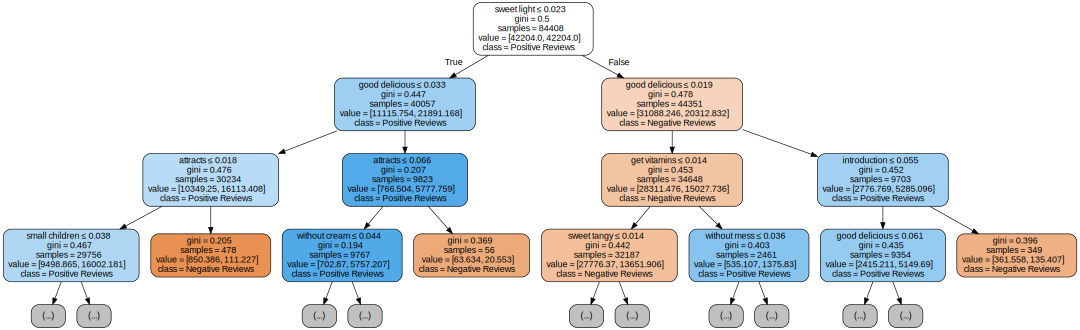

In [47]:
from graphviz import Source
import pydot

pydot.Dot.set_graph_defaults
dot_tree= export_graphviz(best_model, out_file= None, 
                          filled= True, rounded= True, 
                          class_names= ['Negative Reviews', 'Positive Reviews'],
                          #class_names= best_model.classes_,
                          max_depth= 3,
                          feature_names= list(d.values()), 
                          #class_names=best_model.target_names, 
                          special_characters= True)


pdot = pydot.graph_from_dot_data(dot_tree)
pdot[0].set_graph_defaults(size = "\"15,15\"")
graph = Source(pdot[0].to_string()) 
graph

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min


best score :  0.8374551058903336
best parameter :  {'min_samples_split': 500, 'max_depth': 10}


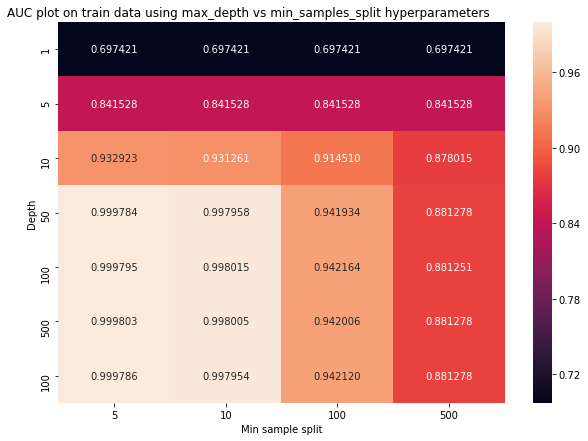

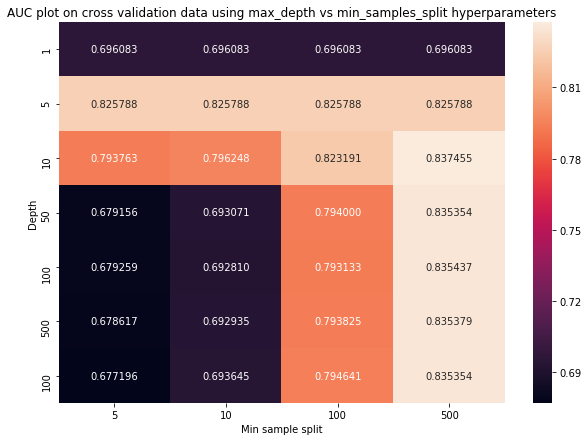

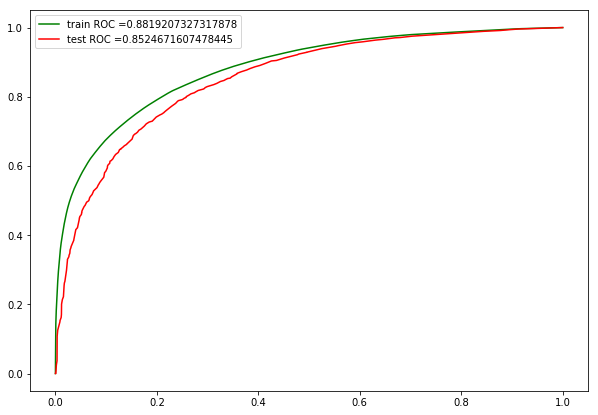

Train confusion matrix: 
[[11982  2609]
 [15950 53867]]

Test confusion matrix: 
[[ 2993   816]
 [ 4243 13051]]

Test Sensitivity or True Positive Rate: 0.41
Test Specificity or False Negative Rate: 0.94


In [48]:
# Please write all the code with proper documentation
depth =  [1, 5, 10, 50, 100, 500, 100]
min_samples_split = [5, 10, 100, 500]

estimator= DecisionTreeClassifier(criterion='gini', splitter='best', class_weight= 'balanced')
param_distributions={
    'max_depth' : depth,
    'min_samples_split' : min_samples_split
}

train= sent_vectors
test= sent_vectors_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
# Plotting train AUC
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))  
ax= sns.heatmap((np.reshape(train_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")

ax.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on train data using max_depth vs min_samples_split hyperparameters                 ")
fig,ax_1= plt.subplots(figsize=(10,7))

ax_1= sns.heatmap((np.reshape(cv_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")
ax_1.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on cross validation data using max_depth vs min_samples_split hyperparameters")


fig, ax2 = plt.subplots(figsize=(10,7))

score_roc_train = best_model.predict_proba(train)[:,1]
score_roc_test = best_model.predict_proba(test)[:,1]
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_AVG_W2V= grid.best_estimator_
AUC_AVG_W2V= grid.best_score_
CM_AVG_W2V= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  4.5min finished


best score :  0.8008935236692601
best parameter :  {'min_samples_split': 500, 'max_depth': 10}


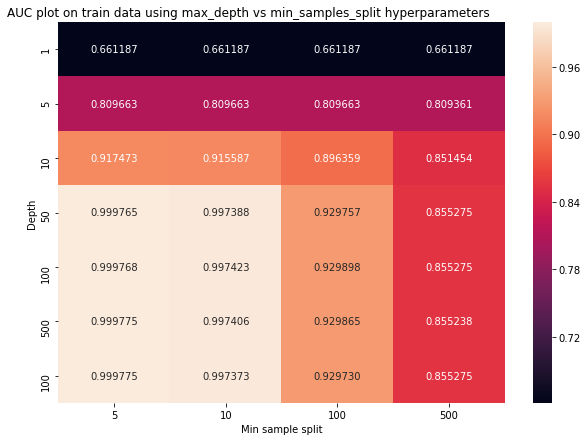

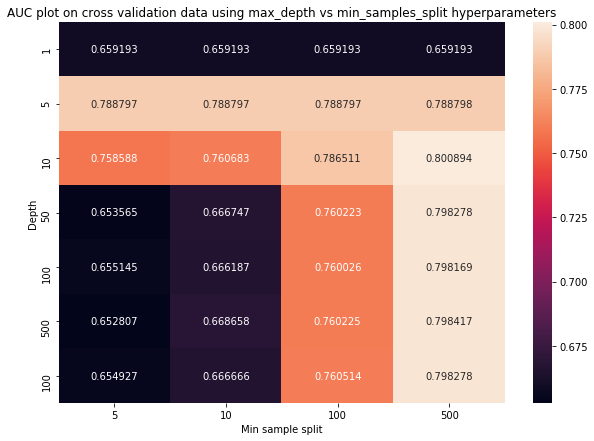

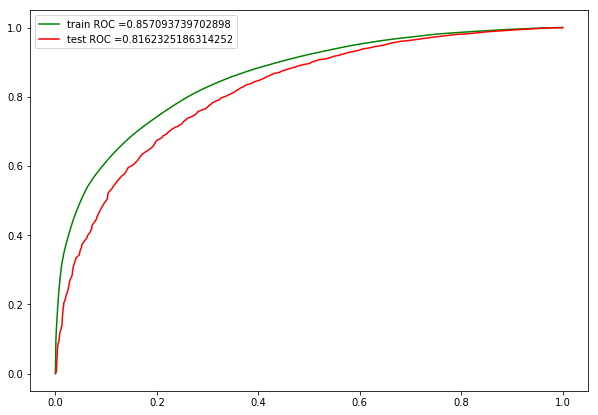

Train confusion matrix: 
[[11407  3184]
 [16709 53108]]

Test confusion matrix: 
[[ 2764  1045]
 [ 4375 12919]]

Test Sensitivity or True Positive Rate: 0.39
Test Specificity or False Negative Rate: 0.93


In [49]:
# Please write all the code with proper documentation
depth =  [1, 5, 10, 50, 100, 500, 100]
min_samples_split = [5, 10, 100, 500]

estimator= DecisionTreeClassifier(criterion='gini', splitter='best', class_weight= 'balanced')
param_distributions={
    'max_depth' : depth,
    'min_samples_split' : min_samples_split
}

train= tfidf_sent_vectors
test= tfidf_sent_vectors_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)# Plotting train AUC
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))  
ax= sns.heatmap((np.reshape(train_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")

ax.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on train data using max_depth vs min_samples_split hyperparameters                 ")
fig,ax_1= plt.subplots(figsize=(10,7))

ax_1= sns.heatmap((np.reshape(cv_auc, (7,4))), yticklabels= depth, xticklabels = min_samples_split, annot=True, fmt="f")
ax_1.set(xlabel= 'Min sample split', ylabel= 'Depth', title= "AUC plot on cross validation data using max_depth vs min_samples_split hyperparameters")


fig, ax2 = plt.subplots(figsize=(10,7))

score_roc_train = best_model.predict_proba(train)[:,1]
score_roc_test = best_model.predict_proba(test)[:,1]
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDF_W2V= grid.best_estimator_
AUC_TFIDF_W2V= grid.best_score_
CM_TFIDF_W2V= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

# [6] Conclusions

+------------+--------------------------+---------------------------------------------------------------------------------+--------------------+
| Vectorizer |          Model           |                                  Hyperparameter                                 |        AUC         |
+------------+--------------------------+---------------------------------------------------------------------------------+--------------------+
|    BOW     | Decision Tree Classifier | DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50, | 0.8175476154573699 |
|            |                          |                                 max_features=None, max_leaf_nodes=None,         |                    |
|            |                          |                           min_impurity_decrease=0.0, min_impurity_split=None,   |                    |
|            |                          |                               min_samples_leaf=1, min_samples_split=500,        |       

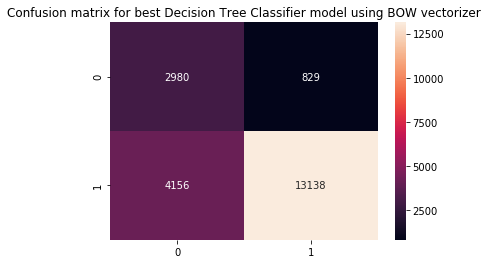

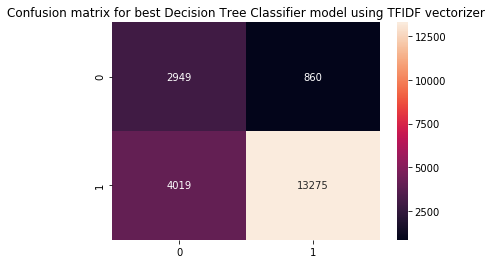

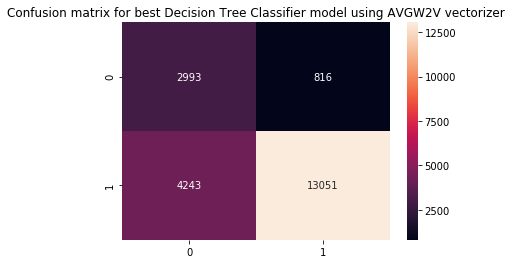

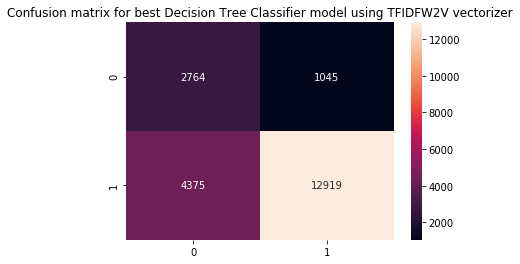

In [50]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
import seaborn as sns
x= PrettyTable(["Vectorizer", "Model", "Hyperparameter", "AUC"])
x.add_row(['BOW', 'Decision Tree Classifier', EST_BOW, AUC_BOW])
x.add_row(['TFIDF', 'Decision Tree Classifier', EST_TFIDF, AUC_TFIDF])
x.add_row(['AVG W2V', 'Decision Tree Classifier', EST_AVG_W2V, AUC_AVG_W2V])
x.add_row(['TFIDF W2V', 'Decision Tree Classifier', EST_TFIDF_W2V, AUC_TFIDF_W2V])
print(x)

ax= sns.heatmap(CM_BOW, annot=True, fmt="d")
ax.set_title('Confusion matrix for best Decision Tree Classifier model using BOW vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDF, annot=True, fmt="d")
ax.set_title('Confusion matrix for best Decision Tree Classifier model using TFIDF vectorizer')
plt.show()

ax= sns.heatmap(CM_AVG_W2V, annot=True, fmt="d")
ax.set_title('Confusion matrix for best Decision Tree Classifier model using AVGW2V vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDF_W2V, annot=True, fmt="d")
ax.set_title('Confusion matrix for best Decision Tree Classifier model using TFIDFW2V vectorizer')
plt.show()